
## **Environment**


In [81]:
import numpy as np
import gym

class SRWE(gym.Env) :
  
  def __init__(self):
    self.state_space = np.arange(9) 
    self.action_space = np.arange(2) 
    self.state = len(self.state_space)//2
    self.terminal = [0,8]
    self.reward_space = [0,1]
    self.prev_state = None

  def reset(self):
    self.state = len(self.state_space)//2
    self.prev_state=None
    return self.state,0

  def seed(self,seed):
    np.random.random(seed)

  def step(self,action):
    self.prev_state = self.state
    reward = 0
    done = 0
    p = np.random.random()
    if(action==0):
      if(p<0.16) : self.state += 1
      elif(p>0.5) : self.state -=1

    if(action==1):
      if(p<0.16) : self.state -= 1
      elif(p>0.5) : self.state +=1

    if(self.state==8) : 
      reward = 1
      done = 1
    
    if(self.state==0): done = 1

    return self.state,reward,done


## **Test cases**

In [82]:
env = SRWE()
count = np.zeros([len(env.state_space)])
print("[state ,action, same state prob ,   state-1 prob ,  state+1 prob ]")
for s in range(1,8) :
  
  for a in env.action_space  :
    count = np.zeros([len(env.state_space)])
    for e in range(100000):
      s_n,r,done = env.step(a)
      count[s_n]+=1
      env.state = s
    if(a==0): action = 'LEFT'
    else : action = 'RIGHT'
    l = [s, action,count[s]/e,count[s-1]/e,count[s+1]/e]
    
    print(l)

[state ,action, same state prob ,   state-1 prob ,  state+1 prob ]
[1, 'LEFT', 0.34078340783407834, 0.4989249892498925, 0.16029160291602915]
[1, 'RIGHT', 0.34047340473404736, 0.16270162701627017, 0.4968349683496835]
[2, 'LEFT', 0.34114341143411436, 0.4995549955499555, 0.15931159311593115]
[2, 'RIGHT', 0.33966339663396633, 0.16046160461604617, 0.4998849988499885]
[3, 'LEFT', 0.34272342723427235, 0.4988349883498835, 0.15844158441584416]
[3, 'RIGHT', 0.33957339573395734, 0.15967159671596717, 0.5007650076500765]
[4, 'LEFT', 0.34015340153401535, 0.4981849818498185, 0.16167161671616717]
[4, 'RIGHT', 0.33914339143391437, 0.16078160781607817, 0.5000850008500085]
[5, 'LEFT', 0.34025340253402536, 0.4991249912499125, 0.16063160631606316]
[5, 'RIGHT', 0.33904339043390436, 0.16224162241622417, 0.4987249872498725]
[6, 'LEFT', 0.33929339293392935, 0.5017350173501735, 0.15898158981589816]
[6, 'RIGHT', 0.33856338563385635, 0.16029160291602915, 0.5011550115501155]
[7, 'LEFT', 0.33919339193391934, 0.5011

#**Decay rate**

In [83]:
def decayLearningRate(e):

  return 0.5*np.exp(-0.005*e)

In [84]:
def decayEpsilon(e):
  return 0.3*np.exp(-0.009*e)

# **Trajectory**

In [85]:
def generateTracjectory(env,Q,eps,maxSteps):
  Trj = []
  done = 0
  count = 0
  while(not done):
    env.seed(count)
    a = np.random.randint(2)
    env.seed(count*3)
    s,r,done = env.step(a)
    Trj.append((env.prev_state,a,r,s))
    count+=1
  return Trj

# **Q-Learning**

In [86]:
def actionSelect(s,Q,eps):
  if(eps < np.random.random()) : a = np.random.randint(2)
  else :
    a = np.argmax(Q[s])

  return a

In [87]:
def QLearning(env,gamma,alpha,eps,noEpisodes):
  Q = np.zeros([len(env.state_space),len(env.action_space)])
  Qs = np.zeros([noEpisodes,len(env.state_space),len(env.action_space)])
  Vs = np.zeros([noEpisodes,len(env.state_space)])
  for e in range(noEpisodes):
    s,done = env.reset()
    alpha = decayLearningRate(e)
    eps = decayEpsilon(e)
    env.seed(e)
    while(not done):
      a = actionSelect(s,Q,eps)
      s_next,r,done = env.step(a)
      
      #print(a)
      td_error = r
      if not done : td_error = td_error + gamma*np.max(Q[s_next])
      Q[s][a] += alpha*(td_error - Q[s][a])
      s = s_next
      
    Qs[e] = Q
    Vs[e] = np.max(Q,axis=1)

  policy = np.argmax(Q,axis=1)
  V = np.max(Q,axis=1)

  return Q,V,policy,Qs,Vs


In [88]:
env = SRWE()
gamma = 0.99
alpha = 0.5
eps = 0.4
noEpisodes = 3000
Q,V,policy,Qs,Vs = QLearning(env,gamma,alpha,eps,noEpisodes) 


In [89]:
policy,V

(array([0, 1, 1, 1, 1, 1, 1, 1, 0]),
 array([0.        , 0.60230411, 0.78205133, 0.85528828, 0.89297613,
        0.92283809, 0.9506195 , 0.97900187, 0.        ]))

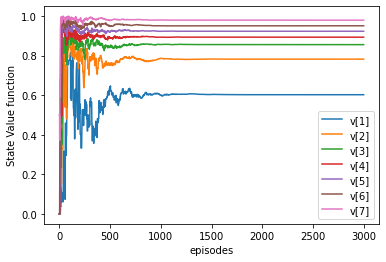

In [90]:
import matplotlib.pyplot as plt
plt.plot(Vs[:,1])
plt.plot(Vs[:,2])
plt.plot(Vs[:,3])
plt.plot(Vs[:,4])
plt.plot(Vs[:,5])
plt.plot(Vs[:,6])
plt.plot(Vs[:,7])
plt.ylabel('State Value function')
plt.xlabel('episodes')
plt.legend([ "v[1]","v[2]","v[3]","v[4]","v[5]","v[6]","v[7]"],loc='lower right')

# **Double Q-Learning**

In [91]:
def Double_Q_Learning(env,gamma,alpha,eps,noEpisodes):
  Q = np.zeros([len(env.state_space),len(env.action_space)])
  Qs = np.zeros([noEpisodes,len(env.state_space),len(env.action_space)])
  Q1 = np.zeros([len(env.state_space),len(env.action_space)])
  Qs1 = np.zeros([noEpisodes,len(env.state_space),len(env.action_space)])
  Q2 = np.zeros([len(env.state_space),len(env.action_space)])
  Qs2 = np.zeros([noEpisodes,len(env.state_space),len(env.action_space)])
  Vs = np.zeros([noEpisodes,len(env.state_space)])
  for e in range(noEpisodes):
    s,done = env.reset()
    alpha = decayLearningRate(e)
    eps = decayEpsilon(e)
    #env.seed(e)
    while(not done):
      a = actionSelect(s,Q1+Q2,eps)
      s_next,r,done = env.step(a)
      env.seed(e*7)
      if(np.random.randint(2)):
        a1 = np.argmax(Q1[s_next])
        td_error = r
        if not done : td_error = td_error + gamma*Q2[s_next][a1]
        Q1[s][a] += alpha*(td_error - Q1[s][a])

      else:
        a2 = np.argmax(Q2[s_next])
        td_error = r
        if not done : td_error = td_error + gamma*Q1[s_next][a2]
        Q2[s][a] += alpha*(td_error - Q2[s][a])

      s = s_next

    Qs1[e] = Q1
    Qs2[e] = Q2
    Q = (Q1+Q2)/2
    Qs = (Qs1+Qs2)/2
    Vs[e] = np.max(Q,axis=1)
    

  V = np.max(Q,axis=1)
  policy = np.argmax(Q,axis=1)

  return Q,V,policy,Qs,Vs


In [92]:
env = SRWE()
gamma = 0.99
alpha = 0.1
eps = 0.4
noEpisodes = 3000
Q,V,policy,Qs,Vs = Double_Q_Learning(env,gamma,alpha,eps,noEpisodes) 

In [93]:
V

array([0.        , 0.56972491, 0.77861767, 0.85530046, 0.89451222,
       0.92547522, 0.95353396, 0.98298841, 0.        ])

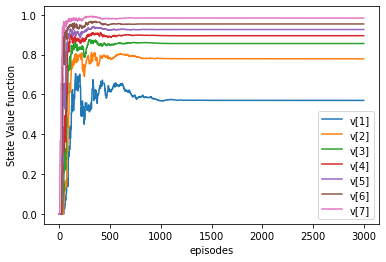

In [94]:
import matplotlib.pyplot as plt

plt.plot(Vs[:,1])
plt.plot(Vs[:,2])
plt.plot(Vs[:,3])
plt.plot(Vs[:,4])
plt.plot(Vs[:,5])
plt.plot(Vs[:,6])
plt.plot(Vs[:,7])
plt.ylabel('State Value function')
plt.xlabel('episodes')
plt.legend([ "v[1]","v[2]","v[3]","v[4]","v[5]","v[6]","v[7]"],loc='lower right')

# **Q(λ)**

In [95]:
def Q_lmd(env,gamma,alpha,eps,lmd,noEpisodes,replaceTrace):
  Q = np.zeros([len(env.state_space),len(env.action_space)])
  Qs = np.zeros([noEpisodes,len(env.state_space),len(env.action_space)])
  Vs = np.zeros([noEpisodes,len(env.state_space)])
  E = np.zeros([len(env.state_space),len(env.action_space)])
  for e in range(noEpisodes):
    s,done = env.reset()
    alpha = decayLearningRate(e)
    eps = decayEpsilon(e)
    E = np.zeros([len(env.state_space),len(env.action_space)])
    env.seed(e)
    a = actionSelect(s,Q,eps)
    while(not done):
      a_next = actionSelect(s,Q,eps)
      s_next,r,done = env.step(a)
      if(a_next==np.argmax(Q[s_next])) : greedy = True
      else : greedy = False
      #print(a)
      td_error = r
      if not done : td_error = td_error + gamma*np.max(Q[s_next])
      td_error = td_error - Q[s][a]
      if(replaceTrace) :  E[s] =  0
      E[s][a] = E[s][a] + 1
      
      
      Q = Q +  alpha*td_error*E
      if(greedy): E = gamma*lmd*E
      else : E = np.zeros([len(env.state_space),len(env.action_space)])
      s = s_next
      a = a_next
      
    Qs[e] = Q
    Vs[e] = np.max(Q,axis=1)

  policy = np.argmax(Q,axis=1)
  V = np.max(Q,axis=1)

  return Q,V,policy,Qs,Vs


In [96]:
env = SRWE()
gamma = 1
alpha = 0.5
eps = 0.3
noEpisodes = 3000
lmd = 0.5
replaceTrace = False
Q,V,policy,Qs,Vs = Q_lmd(env,gamma,alpha,eps,lmd,noEpisodes,replaceTrace) 

In [97]:
V

array([0.        , 0.64772314, 0.88799525, 0.96577971, 0.98877291,
       0.99657109, 0.99885716, 0.99970019, 0.        ])

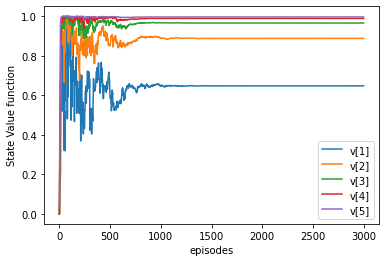

In [98]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(18,8))
plt.plot(Vs[:,1])
plt.plot(Vs[:,2])
plt.plot(Vs[:,3])
plt.plot(Vs[:,4])
plt.plot(Vs[:,5])
#plt.plot(Vs[:,6])
#plt.plot(Vs[:,7])
plt.ylabel('State Value function')
plt.xlabel('episodes')
plt.legend([ "v[1]","v[2]","v[3]","v[4]","v[5]"],loc='lower right')

# **Dyna-Q**

In [99]:
def get_S_A_visited(env,T):
  s_visited = []
  a_taken = []
  for s in env.state_space :
    for a in env.action_space :
      for s_n in env_state_space :
        if(T[s][a][s_n] != 0 ) : 
          s_visited.append(s)
          a_taken.append(a)

  s_visited = list(set(s_visited))
  a_taken =  list(set(s_taken))

In [100]:
def Dyna_Q(env,gamma,alpha,eps,noEpisodes,noPlanning):
  Q = np.zeros([len(env.state_space),len(env.action_space)])
  Qs = np.zeros([noEpisodes,len(env.state_space),len(env.action_space)])
  T = np.zeros([len(env.state_space),len(env.action_space),len(env.state_space)])
  R = np.zeros([len(env.state_space),len(env.action_space),len(env.state_space)])

  Vs = np.zeros([noEpisodes,len(env.state_space)])
  for e in range(noEpisodes):
    s,done = env.reset()
    alpha = decayLearningRate(e)
    eps = decayEpsilon(e)
    env.seed(e)
    while(not done):
      a = actionSelect(s,Q,eps)
      s_next,r,done = env.step(a)
      T[s,a,s_next] += 1
      rDiff = r - R[s,a,s_next]
      R[s,a,s_next] += rDiff/T[s,a,s_next]
      
      td_error = r
      if not done : td_error = td_error + gamma*np.max(Q[s_next])
      Q[s][a] += alpha*(td_error - Q[s][a])
      s_bk = s_next
      for i in range(noPlanning):
        if(np.sum(Q==0)) : break
        s_visited,a_taken = get_S_A_visited(env,T)
        s = np.random.choice(s_visited)
        a = np.random.choice(a_taken)
        prob = T[s][a][:]/np.sum(T[s][a][:])
        s_n = np.random.choice(env.state_space,1,prob)
        r = R[s,a,s_n]
        Q[s,a] += alpha*(r + gamma*np.max(Q[s_n]) - Q[s,a])
      
      s = s_bk

      
    Qs[e] = Q
    Vs[e] = np.max(Q,axis=1)

  policy = np.argmax(Q,axis=1)
  
  V = np.max(Q,axis=1)

  return Q,V,policy,Qs,Vs


In [101]:
env = SRWE()
gamma = 0.99
alpha = 0.5
eps = 0.3
noEpisodes = 3000
noPlanning = 30
Q,V,policy,Qs,Vs = Dyna_Q(env,gamma,alpha,eps,noEpisodes,noPlanning) 
for i in env.terminal:
  policy[i] = -5

In [102]:
V

array([0.        , 0.5712891 , 0.76634206, 0.84349133, 0.88880949,
       0.92178567, 0.9502613 , 0.98010431, 0.        ])

In [103]:
policy

array([-5,  1,  1,  1,  1,  1,  1,  1, -5])

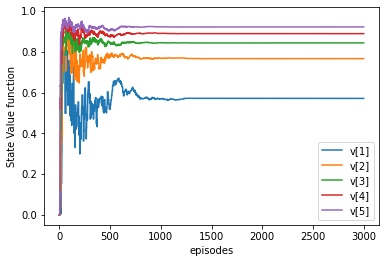

In [104]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(9,6))
plt.plot(Vs[:,1])
plt.plot(Vs[:,2])
plt.plot(Vs[:,3])
plt.plot(Vs[:,4])
plt.plot(Vs[:,5])
#plt.plot(Vs[:,6])
#plt.plot(Vs[:,7])
plt.ylabel('State Value function')
plt.xlabel('episodes')
plt.legend([ "v[1]","v[2]","v[3]","v[4]","v[5]"],loc='lower right')

# **Trajetory sampling**

In [105]:
def Trajectory_Sampling(env,gamma,alpha,eps,maxTrajectory,noEpisodes):
  Q = np.zeros([len(env.state_space),len(env.action_space)])
  Qs = np.zeros([noEpisodes,len(env.state_space),len(env.action_space)])
  T = np.zeros([len(env.state_space),len(env.action_space),len(env.state_space)])
  R = np.zeros([len(env.state_space),len(env.action_space),len(env.state_space)])

  Vs = np.zeros([noEpisodes,len(env.state_space)])
  for e in range(noEpisodes):
    s,done = env.reset()
    alpha = decayLearningRate(e)
    eps = decayEpsilon(e)
    env.seed(e)
    while(not done):
      a = actionSelect(s,Q,eps)
      s_next,r,done = env.step(a)
      T[s,a,s_next] += 1
      rDiff = r - R[s,a,s_next]
      R[s,a,s_next] += rDiff/T[s,a,s_next]
      
      td_error = r
      if not done : td_error = td_error + gamma*np.max(Q[s_next])
      Q[s][a] += alpha*(td_error - Q[s][a])
      s_bk = s_next
      for i in range(maxTrajectory):
        if(np.sum(Q==0)) : break
        a = actionSelect(s,Q,eps)
        if(not np.sum(T[s][a])): break
        prob = T[s][a][:]/np.sum(T[s][a][:])
        s_n = np.random.choice(env.state_space,1,prob)
        r = R[s,a,s_n]
        Q[s,a] += alpha*(r + gamma*np.max(Q[s_n]) - Q[s,a])
      
      s = s_bk

      
    Qs[e] = Q
    Vs[e] = np.max(Q,axis=1)

  policy = np.argmax(Q,axis=1)
  
  V = np.max(Q,axis=1)

  return Q,V,policy,Qs,Vs


In [106]:
env = SRWE()
gamma = 0.99
alpha = 0.5
eps = 0.3
noEpisodes = 3000
maxTrajectory = 30
Q,V,policy,Qs,Vs = Trajectory_Sampling(env,gamma,alpha,eps,maxTrajectory,noEpisodes) 


In [107]:
V

array([0.        , 0.57763425, 0.76648187, 0.84359866, 0.88555835,
       0.91798422, 0.94910943, 0.97928807, 0.        ])

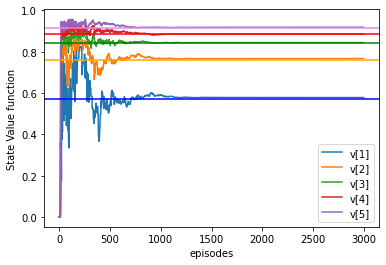

In [108]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(15,12))
plt.plot(Vs[:,1])
plt.plot(Vs[:,2])
plt.plot(Vs[:,3])
plt.plot(Vs[:,4])
plt.plot(Vs[:,5])

plt.axhline(y=0.91549203, color='violet', linestyle='-',)
plt.axhline(y=0.88447723, color='red', linestyle='-',)
plt.axhline(y=0.84283579, color='green', linestyle='-',)
plt.axhline(y=0.76, color='orange', linestyle='-',)
plt.axhline(y=0.57, color='blue', linestyle='-',)
plt.ylabel('State Value function')
plt.xlabel('episodes')
plt.legend([ "v[1]","v[2]","v[3]","v[4]","v[5]"],loc='lower right')

# **True values**

In [109]:
gamma = 1
g = gamma 
A = np.array([[0.33*gamma - 1, 0.5*gamma, 0, 0, 0, 0, 0],
    [0.16*gamma, 0.33*gamma-1, 0.5*gamma, 0, 0, 0, 0],
    [0, .16*g,  .33*g-1, 0.5*g, 0 ,0,0],
    [0, 0, 0.16*g, -1+0.33*g, 0.5*gamma, 0, 0],
    [0, 0, 0, 0.16*g, -1+0.33*g, 0.5*gamma, 0],
    [0, 0, 0, 0, .16*g, -1+0.33*g, 0.5*g ],
    [0, 0, 0, 0, 0, 0.16*g, -1+.33*g]])
b = np.array([[0],[0], [0], [0], [0],[0], [-0.5]])
v_sol = np.linalg.solve(A, b)
    
v_sol = v_sol.flatten()
print("optimal solution:\n[ v(1), v(2), v(3), v(4), v(5), v(6),v(7)] :")
print(v_sol)


optimal solution:
[ v(1), v(2), v(3), v(4), v(5), v(6),v(7)] :
[0.57118175 0.76538355 0.84283579 0.88447723 0.91549203 0.94372661
 0.9716362 ]
